<a href="https://colab.research.google.com/github/aepstar/banjir-ciliwung/blob/main/Multivariate_Multi_step_LSTM_Manggarai_Only_v0_6_6_9999.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pemodelan prediksi ketinggian muka air di Katulampa, Depok, KBR2, KBR4 dan Manggarai.

Data training dimulai dari tanggal 2022-08-01 00:00:00 sampai dengan 2022-12-31 23:59:00. Data testing dimulai dari 2023-01-01 00:00:00 sampai 2023-03-28 00:00:00.

Pembuatan model dengan parameter LSTM(100), data historis selama 7 hari (7x24 jam) untuk memprediksi 6 jam ke depan.

Scaler menggunakan MinMaxdScaler()

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# multivariate multi-step data preparation
import pandas as pd
from numpy import array, hstack, delete, squeeze
from numpy.random import seed
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint
from keras import optimizers
from tensorflow.random import set_seed

from __future__ import print_function

import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"


import matplotlib.pyplot as plt
import math

%matplotlib inline


In [ ]:
os.listdir("drive/Shareddrives")

['CRM',
 'JSC Pengendalian Banjir DKI',
 'Manticore Indonesia',
 'Materi Training JSC',
 'Multimedia Starcore',
 'Outing Starcore',
 'SAB Wyeth',
 'SAS HACKATHON 2023',
 'SCADS',
 'SCADS - Core',
 'Skystar Omnisight',
 'Starcore Anniversary',
 'Starcore Event Organizer',
 'StarCore Learning Center',
 'Transformasi Digital - JSC',
 'Vivi Program']

In [ ]:
os.listdir("drive/Shareddrives/JSC Pengendalian Banjir DKI/Flood Mgt 2022-2023/Data")

In [ ]:
tma = pd.read_csv("drive/Shareddrives/JSC Pengendalian Banjir DKI/Flood Mgt 2022-2023/Data/dsda_rupom_tma_wide.csv", sep = ",")
tma = tma.drop(columns=['BDR5'])

In [ ]:
tma.head()

,tanggal,Katulampa,Depok,Manggarai,KBR2,KBR4
0,2022-08-01 00:00:00,18.0,77.0,585.0,913.128078,1132.861352
1,2022-08-01 01:00:00,18.0,77.0,584.0,912.531145,1132.817396
2,2022-08-01 02:00:00,18.0,76.0,584.0,913.884112,1132.781257
3,2022-08-01 03:00:00,18.0,76.0,583.0,912.527483,1132.764147
4,2022-08-01 04:00:00,19.0,77.0,583.0,911.968800,1132.749544


In [ ]:
tma[tma['Manggarai'].isna()]

,tanggal,Katulampa,Depok,Manggarai,KBR2,KBR4


In [ ]:
tma['tanggal'] = pd.to_datetime(tma['tanggal'])
tma.head()


,tanggal,Katulampa,Depok,Manggarai,KBR2,KBR4
0,2022-08-01 00:00:00,18.0,77.0,585.0,913.128078,1132.861352
1,2022-08-01 01:00:00,18.0,77.0,584.0,912.531145,1132.817396
2,2022-08-01 02:00:00,18.0,76.0,584.0,913.884112,1132.781257
3,2022-08-01 03:00:00,18.0,76.0,583.0,912.527483,1132.764147
4,2022-08-01 04:00:00,19.0,77.0,583.0,911.968800,1132.749544


In [ ]:
print(tma.tanggal.min(), tma.tanggal.max())

2022-08-01 00:00:00 2023-03-28 00:00:00


In [ ]:
# Data untukk training
tma_train = tma.loc[(tma['tanggal'] >= '2022-08-01 00:00:00')]
tma_train = tma_train.loc[(tma_train['tanggal'] <= '2022-12-31 23:59:00')]
tma_train = tma_train.loc[(tma_train.tanggal.dt.minute == 0)]


In [ ]:
print(tma_train)

In [ ]:
tma_train[tma_train['Katulampa'].isna()]

,tanggal,Katulampa,Depok,Manggarai,KBR2,KBR4


In [ ]:
tma_test = tma.loc[(tma['tanggal'] > '2022-12-31 23:59:00')]
tma_test = tma_test.loc[(tma_test.tanggal.dt.minute == 0)]
print(tma_test)

                 tanggal  Katulampa  Depok  Manggarai        KBR2         KBR4
3672 2023-01-01 00:00:00       29.0  118.0      669.0  860.681681  1006.353364
3673 2023-01-01 01:00:00       35.0  133.0      700.0  866.996937  1006.397310
3674 2023-01-01 02:00:00       35.0  131.0      704.0  870.767050  1006.895161
3675 2023-01-01 03:00:00       36.0  128.0      705.0  873.458741  1006.746029
3676 2023-01-01 04:00:00       32.0  127.0      707.0  876.001144  1006.904927
...                  ...        ...    ...        ...         ...          ...
5732 2023-03-27 20:00:00       21.0   91.0      684.0  932.351394  1130.277781
5733 2023-03-27 21:00:00       21.0  105.0      671.0  928.778138  1130.277781
5734 2023-03-27 22:00:00       21.0  105.0      674.0  923.716009  1130.443189
5735 2023-03-27 23:00:00       20.0  103.0      668.0  919.206459  1130.453565
5736 2023-03-28 00:00:00       19.0  102.0      664.0  916.223625  1130.453972

[2065 rows x 6 columns]


In [ ]:
scaler = MinMaxScaler()
scaler.fit(tma_train[['Katulampa', 'Depok', 'KBR2', 'KBR4', 'Manggarai']])

MinMaxScaler()

In [ ]:
tma_scaled = scaler.transform(tma_train[['Katulampa', 'Depok', 'KBR2', 'KBR4', 'Manggarai']])
tma_scaled

array([[0.12318841, 0.21755725, 0.27204854, 0.9390033 , 0.03773585],
       [0.12318841, 0.21755725, 0.27053269, 0.93869339, 0.03396226],
       [0.12318841, 0.21374046, 0.27396842, 0.9384386 , 0.03396226],
       ...,
       [0.18115942, 0.35877863, 0.06546755, 0.03865078, 0.29811321],
       [0.1884058 , 0.36641221, 0.09315871, 0.03417966, 0.32075472],
       [0.19565217, 0.37022901, 0.11801703, 0.04653729, 0.33962264]])

In [ ]:
tma_scaled[:, 0]

array([0.12318841, 0.12318841, 0.12318841, ..., 0.18115942, 0.1884058 ,
       0.19565217])

In [ ]:
scaler.inverse_transform(tma_scaled)

array([[  18.        ,   77.        ,  913.12807843, 1132.8613519 ,
         585.        ],
       [  18.        ,   77.        ,  912.5311455 , 1132.81739574,
         584.        ],
       [  18.        ,   76.        ,  913.8841121 , 1132.78125729,
         584.        ],
       ...,
       [  26.        ,  114.        ,  831.77789914, 1005.15929447,
         654.        ],
       [  27.        ,  116.        ,  842.68248956, 1004.52512952,
         660.        ],
       [  28.        ,  117.        ,  852.47152341, 1006.27788251,
         665.        ]])

In [ ]:
tma_train.head()

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# # define input sequence
# in_katulampa = array(tma_train['Katulampa'])
# in_depok = array(tma_train['Depok'])
# in_kbr2 = array(tma_train['KBR2'])
# in_kbr4 = array(tma_train['KBR4'])
# in_bdr5 = array(tma_train['BDR5'])
# out_manggarai = array(tma_train['Manggarai'])

in_katulampa = array(tma_scaled[:, 0])
in_depok = array(tma_scaled[:, 1])
in_kbr2 = array(tma_scaled[:, 2])
in_kbr4 = array(tma_scaled[:, 3])
# in_bdr5 = array(tma_scaled[:, 4])
out_manggarai = array(tma_scaled[:, 4])

# convert to [rows, columns] structure
in_katulampa = in_katulampa.reshape((len(in_katulampa), 1))
in_depok = in_depok.reshape((len(in_depok), 1))
in_kbr2 = in_kbr2.reshape((len(in_kbr2), 1))
in_kbr4 = in_kbr4.reshape((len(in_kbr4), 1))
# in_bdr5 = in_bdr5.reshape((len(in_bdr5), 1))
out_manggarai = out_manggarai.reshape((len(out_manggarai), 1))

# horizontally stack columns
# dataset = hstack((in_katulampa, in_depok, in_kbr2, in_kbr4, in_bdr5, out_manggarai))
dataset = hstack((in_katulampa, in_depok, in_kbr2, in_kbr4, out_manggarai))


In [ ]:
# choose a number of time steps
n_hari = 2
n_jam = 24
n_steps_in = n_hari*n_jam
n_steps_out = 6

# convert into input/output
X_train, y_train = split_sequences(dataset, n_steps_in, n_steps_out)

# the dataset knows the number of features, e.g. 2
n_features = X_train.shape[2]
print(X_train.shape)

(3619, 48, 5)


In [ ]:
from sklearn.model_selection import TimeSeriesSplit

test_scaled = scaler.transform(tma_test[['Katulampa', 'Depok', 'KBR2', 'KBR4', 'Manggarai']])

array_katulampa = array(test_scaled[:, 0])
array_depok = array(test_scaled[:, 1])
array_kbr2 = array(test_scaled[:, 2])
array_kbr4 = array(test_scaled[:, 3])
# array_bdr5 = array(test_scaled[:, 4])
array_manggarai = array(test_scaled[:, 4])

# convert to [rows, columns] structure
array_katulampa = array_katulampa.reshape((len(array_katulampa), 1))
array_depok = array_depok.reshape((len(array_depok), 1))
array_kbr2 = array_kbr2.reshape((len(array_kbr2), 1))
array_kbr4 = array_kbr4.reshape((len(array_kbr4), 1))
# array_bdr5 = array_bdr5.reshape((len(array_bdr5), 1))
array_manggarai = array_manggarai.reshape((len(array_manggarai), 1))

# test_input = hstack((array_katulampa, array_depok, array_kbr2, array_kbr4, array_bdr5, array_manggarai))
test_input = hstack((array_katulampa, array_depok, array_kbr2, array_kbr4, array_manggarai))
X_test, y_test = split_sequences(test_input, n_steps_in, n_steps_out)
# print(x_input)


In [ ]:
# fix random seed for reproducibility
seed(101)
set_seed(101)

# define model
checkpoint_filepath = 'best_model_mang.h5'
model = Sequential()
model.add(LSTM(128, activation = 'relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(128, activation = 'relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(128, activation = 'relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
# model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model_checkpoint_callback = ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True,
                                            monitor='val_loss', mode='min', save_best_only=True)
# fit model
model_mang = model.fit(X_train, y_train, epochs = 100, batch_size = 150, verbose=1,
                       validation_split=0.25, callbacks=[model_checkpoint_callback])


Epoch 1/100
19/19 [==============================] - 12s 454ms/step - loss: 0.1366 - val_loss: 0.0443
Epoch 2/100
19/19 [==============================] - 7s 339ms/step - loss: 0.0500 - val_loss: 0.0394
Epoch 3/100
19/19 [==============================] - 7s 379ms/step - loss: 0.0311 - val_loss: 0.0426
Epoch 4/100
19/19 [==============================] - 8s 390ms/step - loss: 0.0187 - val_loss: 0.0450
Epoch 5/100
19/19 [==============================] - 7s 351ms/step - loss: 0.0130 - val_loss: 0.0458
Epoch 6/100
19/19 [==============================] - 8s 423ms/step - loss: 0.0107 - val_loss: 0.0459
Epoch 7/100
19/19 [==============================] - 6s 322ms/step - loss: 0.0094 - val_loss: 0.0452
Epoch 8/100
19/19 [==============================] - 9s 461ms/step - loss: 0.0087 - val_loss: 0.0465
Epoch 9/100
19/19 [==============================] - 6s 320ms/step - loss: 0.0079 - val_loss: 0.0482
Epoch 10/100
19/19 [==============================] - 9s 458ms/step - loss: 0.0076 - val_l

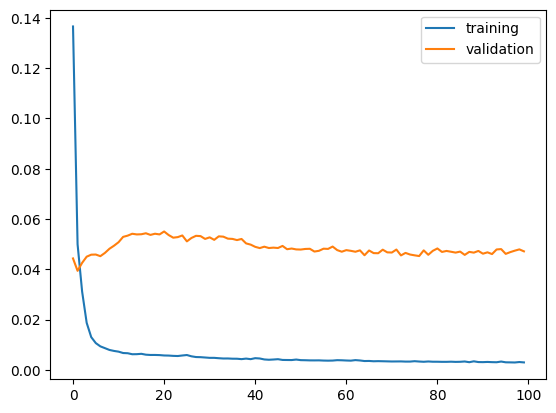

In [ ]:
plt.plot(range(len(model_mang.history['loss'])), model_mang.history['loss'], label = 'training')
plt.plot(range(len(model_mang.history['val_loss'])), model_mang.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

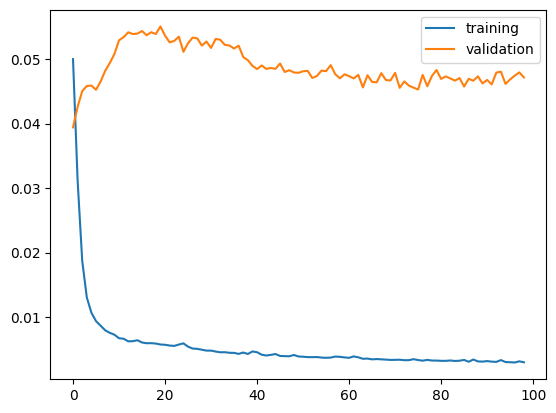

In [ ]:
plt.plot(range(len(model_mang.history['loss'][1:])), model_mang.history['loss'][1:], label = 'training')
plt.plot(range(len(model_mang.history['val_loss'][1:])), model_mang.history['val_loss'][1:], label = 'validation')
plt.legend()
plt.show()

In [ ]:
tma_test.head()

,tanggal,Katulampa,Depok,Manggarai,KBR2,KBR4
3672,2023-01-01 00:00:00,29.0,118.0,669.0,860.681681,1006.353364
3673,2023-01-01 01:00:00,35.0,133.0,700.0,866.996937,1006.397310
3674,2023-01-01 02:00:00,35.0,131.0,704.0,870.767050,1006.895161
3675,2023-01-01 03:00:00,36.0,128.0,705.0,873.458741,1006.746029
3676,2023-01-01 04:00:00,32.0,127.0,707.0,876.001144,1006.904927


In [ ]:
# Prediction
test_scaled = scaler.transform(tma_test[['Katulampa', 'Depok', 'KBR2', 'KBR4', 'Manggarai']])

array_katulampa = array(test_scaled[:, 0])
array_depok = array(test_scaled[:, 1])
array_kbr2 = array(test_scaled[:, 2])
array_kbr4 = array(test_scaled[:, 3])
# array_bdr5 = array(test_scaled[:, 4])
array_manggarai = array(test_scaled[:, 4])

# convert to [rows, columns] structure
array_katulampa = array_katulampa.reshape((len(array_katulampa), 1))
array_depok = array_depok.reshape((len(array_depok), 1))
array_kbr2 = array_kbr2.reshape((len(array_kbr2), 1))
array_kbr4 = array_kbr4.reshape((len(array_kbr4), 1))
# array_bdr5 = array_bdr5.reshape((len(array_bdr5), 1))
array_manggarai = array_manggarai.reshape((len(array_manggarai), 1))

# test_input = hstack((array_katulampa, array_depok, array_kbr2, array_kbr4, array_bdr5, array_manggarai))
test_input = hstack((array_katulampa, array_depok, array_kbr2, array_kbr4, array_manggarai))
X_test, y_test = split_sequences(test_input, n_steps_in, n_steps_out)
# print(x_input)

# x_input = x_input.reshape((1, n_steps_in, n_features))
y_pred = model.predict(X_test, verbose = 0)


In [ ]:
print(len(X_train), len(y_train), len(X_test), len(y_test), len(y_pred))

3619 3619 2012 2012 2012


In [ ]:
print(y_pred)
# y_pred = scaler.inverse_transform(squeeze(y_pred))
# print(y_pred)

In [ ]:
scaler.inverse_transform(y_test[0])

array([[  33.        ,  128.        ,  831.36941004, 1003.90073035,
         680.        ],
       [  28.        ,  125.        ,  823.84513548, 1006.78875456,
         673.        ],
       [  28.        ,  126.        ,  817.81848814, 1007.8853696 ,
         667.        ],
       [  28.        ,  128.        ,  813.35775723, 1007.59504128,
         649.        ],
       [  27.        ,  125.        ,  811.12041332, 1007.21315882,
         660.        ],
       [  30.        ,  125.        ,  812.57317901, 1007.42149533,
         661.        ]])

In [ ]:
scaler.inverse_transform(y_pred[0])

In [ ]:
len(X_test[0])

In [ ]:
X_test[0]

In [ ]:
print(len(y_pred[0]), n_steps_out)

In [ ]:
y_pred[0][0][0]

In [ ]:
len(y_test[0])

In [ ]:
y_test_scale_inv = []
y_pred_scale_inv = []
for i in range(len(y_test)):
  y_test_scale_inv.append(scaler.inverse_transform(y_test[i]))
  y_pred_scale_inv.append(scaler.inverse_transform(y_pred[i]))

In [ ]:
y_pred_scale_inv[0]

array([[  27.982012,  114.50074 ,  881.0097  , 1132.7443  ,  643.21454 ],
       [  27.80202 ,  114.46703 ,  882.19507 , 1132.9863  ,  643.78406 ],
       [  27.653538,  114.48644 ,  882.93524 , 1132.9609  ,  643.76855 ],
       [  27.462954,  114.164665,  883.3559  , 1132.8256  ,  643.42993 ],
       [  27.469267,  114.37511 ,  884.02124 , 1132.9294  ,  643.72144 ],
       [  27.62266 ,  114.80609 ,  884.6806  , 1132.6412  ,  644.8582  ]],
      dtype=float32)

Katulampa RMSE: 6.697 cm


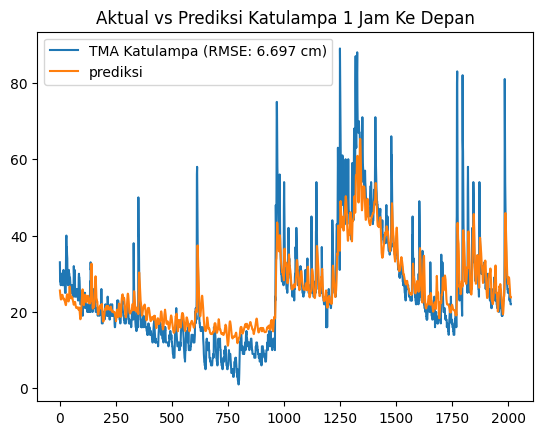

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 1
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
# for i in range(1500,1800):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

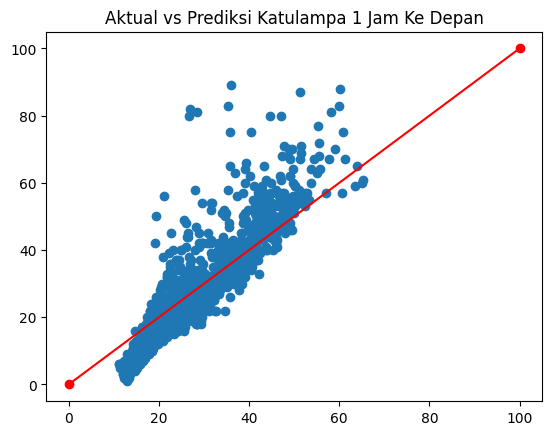

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Katulampa RMSE: 14.670 cm


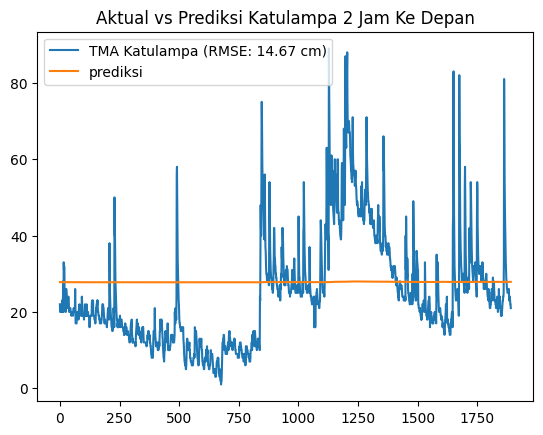

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 2
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

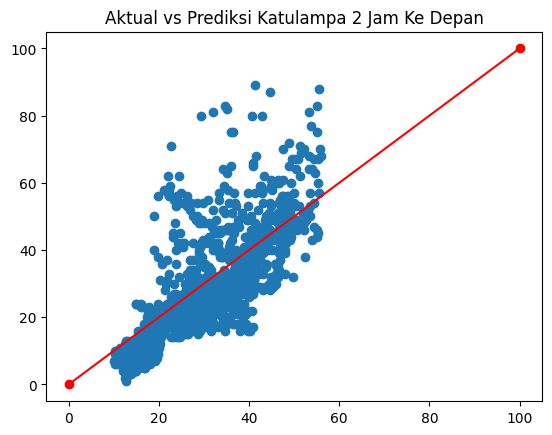

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Katulampa RMSE: 9.415 cm


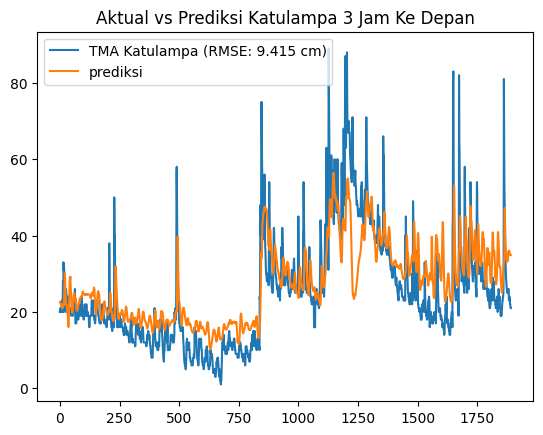

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 3
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

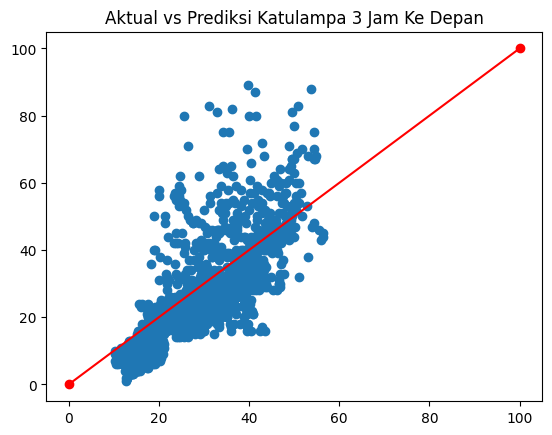

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Katulampa RMSE: 9.747 cm


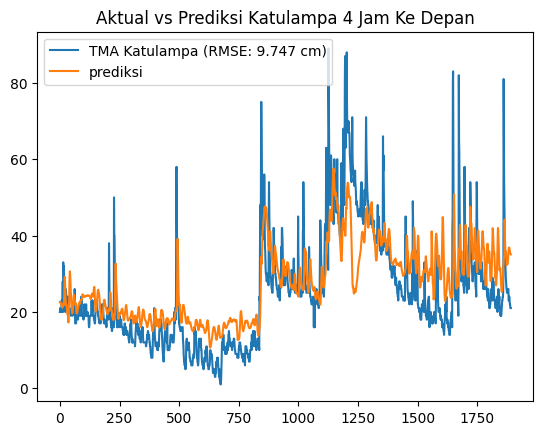

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 4
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

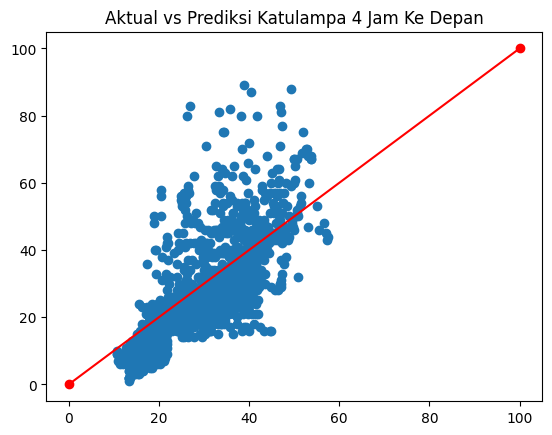

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

Katulampa RMSE: 10.045 cm


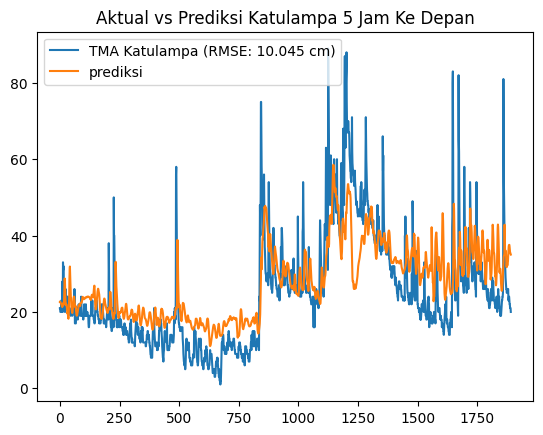

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 5
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

In [ ]:
# RMSE Katulampa n jam ke depan
lokasi = 'Katulampa'
n = 6
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][0])
  y_test_list.append(y_test_scale_inv[i][n - 1][0])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 0
y_0 = 0
x_1 = 100
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 1
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 2
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 3
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 4
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSEm: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 300
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 5
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 300
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.show()

In [ ]:
# RMSE Depok n jam ke depan
lokasi = 'Depok'
n = 6
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][1])
  y_test_list.append(y_test_scale_inv[i][n - 1][1])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 50
y_0 = 50
x_1 = 300
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 1
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 2
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 3
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 4
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 5
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR2 n jam ke depan
lokasi = 'KBR2'
n = 6
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][2])
  y_test_list.append(y_test_scale_inv[i][n - 1][2])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 800
y_0 = 800
x_1 = 1200
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 1
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 2
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 3
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 4
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 5
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE KBR4 n jam ke depan
lokasi = 'KBR4'
n = 6
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][3])
  y_test_list.append(y_test_scale_inv[i][n - 1][3])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 1100
y_0 = 1100
x_1 = 1180
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 1
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 2
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 3
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 4
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 5
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
# RMSE Manggarai n jam ke depan
lokasi = 'Manggarai'
n = 6
y_pred_list = []
y_test_list = []
for i in range(len(y_test_scale_inv)):
  y_pred_list.append(y_pred_scale_inv[i][n - 1][4])
  y_test_list.append(y_test_scale_inv[i][n - 1][4])

print(f'{lokasi} RMSE: %.3f cm' % sqrt(mean_squared_error(y_test_list, y_pred_list)))

plt.plot(y_test_list, label = f"TMA {lokasi} (RMSE: {round(sqrt(mean_squared_error(y_test_list, y_pred_list)), 3)} cm)")
plt.plot(y_pred_list, label = "prediksi")
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.scatter(y_pred_list, y_test_list)
slope = 1
x_0 = 550
y_0 = 550
x_1 = 800
y_1 = slope*(x_1 - x_0) + y_0

ax.scatter([x_0, x_1], [y_0, y_1], c='r')
ax.plot([x_0, x_1], [y_0, y_1], c='r')
plt.title(f"Aktual vs Prediksi {lokasi} {n} Jam Ke Depan")
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
x = 0
lokasi = 'Katulampa'
list_test = []
list_pred = []
list_diff = []
jam = []
for i in range(len(y_test_scale_inv)):
  for j in range(6):
    jam.append(j+1)
    list_test.append(y_test_scale_inv[i][j][x])
    list_pred.append(y_pred_scale_inv[i][j][x])
    list_diff.append(y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])

data = pd.DataFrame([jam, list_test, list_pred, list_diff])
data = data.T
data.columns=["Jam", "Test", "Pred", "Diff"]

sns.boxplot(x = "Jam", y = "Diff", data=data).set(xlabel = f"{lokasi} n Jam Ke Depan", ylabel = "Selisih (Test - Prediksi)")

data.boxplot(by = "Jam", column = ['Diff'], grid = False)
plt.axhline(0, linestyle = "dashed", linewidth = 0.5, color='r')
plt.xlabel(f"{lokasi} n Jam ke Depan")
plt.ylabel("Selisih (Test - Prediksi)")
plt.title("Sebaran Selisih Prediksi")
plt.show()

In [ ]:
x = 1
lokasi = 'Depok'
list_test = []
list_pred = []
list_diff = []
list_diff_squared = []
jam = []
for i in range(len(y_test_scale_inv)):
  for j in range(6):
    jam.append(j+1)
    list_test.append(y_test_scale_inv[i][j][x])
    list_pred.append(y_pred_scale_inv[i][j][x])
    list_diff.append(y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])
    list_diff_squared.append((y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])**2)

data = pd.DataFrame([jam, list_test, list_pred, list_diff, list_diff_squared])
data = data.T
data.columns=["Jam", "Test", "Pred", "Diff", "Diff_Squared"]

sns.boxplot(x = "Jam", y = "Diff", data=data).set(xlabel = f"{lokasi} n Jam Ke Depan", ylabel = "Selisih (Test - Prediksi)")

data.boxplot(by = "Jam", column = ['Diff'], grid = False)
plt.axhline(0, linestyle = "dashed", linewidth = 0.5, color='r')
plt.xlabel(f"{lokasi} n Jam ke Depan")
plt.ylabel("Selisih (Test - Prediksi)")
plt.title("Sebaran Selisih Prediksi")
plt.show()

In [ ]:
x = 2
lokasi = 'KBR2'
list_test = []
list_pred = []
list_diff = []
jam = []
for i in range(len(y_test_scale_inv)):
  for j in range(6):
    jam.append(j+1)
    list_test.append(y_test_scale_inv[i][j][x])
    list_pred.append(y_pred_scale_inv[i][j][x])
    list_diff.append(y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])

data = pd.DataFrame([jam, list_test, list_pred, list_diff])
data = data.T
data.columns=["Jam", "Test", "Pred", "Diff"]

sns.boxplot(x = "Jam", y = "Diff", data=data).set(xlabel = f"{lokasi} n Jam Ke Depan", ylabel = "Selisih (Test - Prediksi)")

data.boxplot(by = "Jam", column = ['Diff'], grid = False)
plt.axhline(0, linestyle = "dashed", linewidth = 0.5, color='r')
plt.xlabel(f"{lokasi} n Jam ke Depan")
plt.ylabel("Selisih (Test - Prediksi)")
plt.title("Sebaran Selisih Prediksi")
plt.show()

In [ ]:
x = 3
lokasi = 'KBR4'
list_test = []
list_pred = []
list_diff = []
jam = []
for i in range(len(y_test_scale_inv)):
  for j in range(6):
    jam.append(j+1)
    list_test.append(y_test_scale_inv[i][j][x])
    list_pred.append(y_pred_scale_inv[i][j][x])
    list_diff.append(y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])

data = pd.DataFrame([jam, list_test, list_pred, list_diff])
data = data.T
data.columns=["Jam", "Test", "Pred", "Diff"]

sns.boxplot(x = "Jam", y = "Diff", data=data).set(xlabel = f"{lokasi} n Jam Ke Depan", ylabel = "Selisih (Test - Prediksi)")

data.boxplot(by = "Jam", column = ['Diff'], grid = False)
plt.axhline(0, linestyle = "dashed", linewidth = 0.5, color='r')
plt.xlabel(f"{lokasi} n Jam ke Depan")
plt.ylabel("Selisih (Test - Prediksi)")
plt.title("Sebaran Selisih Prediksi")
plt.show()

In [ ]:
x = 4
lokasi = 'Manggarai'
list_test = []
list_pred = []
list_diff = []
jam = []
for i in range(len(y_test_scale_inv)):
  for j in range(6):
    jam.append(j+1)
    list_test.append(y_test_scale_inv[i][j][x])
    list_pred.append(y_pred_scale_inv[i][j][x])
    list_diff.append(y_test_scale_inv[i][j][x] - y_pred_scale_inv[i][j][x])

data = pd.DataFrame([jam, list_test, list_pred, list_diff])
data = data.T
data.columns=["Jam", "Test", "Pred", "Diff"]

sns.boxplot(x = "Jam", y = "Diff", data=data).set(xlabel = f"{lokasi} n Jam Ke Depan", ylabel = "Selisih (Test - Prediksi)")

data.boxplot(by = "Jam", column = ['Diff'], grid = False)
plt.axhline(0, linestyle = "dashed", linewidth = 0.5, color='r')
plt.xlabel(f"{lokasi} n Jam ke Depan")
plt.ylabel("Selisih (Test - Prediksi)")
plt.title("Sebaran Selisih Prediksi")
plt.show()

In [ ]:
model.save('drive/Shareddrives/JSC Pengendalian Banjir DKI/ciliwung_manggarai_multivariate_multistep_lstm_7hari_5lokasi_0.6.6')

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# tf.keras.models.load_model('drive/Shareddrives/JSC Pengendalian Banjir DKI/ciliwung_manggarai_multivariate_multistep_lstm_7hari_5lokasi_0.6.6')